## Explaining ResNet34 with SHAP


The SHAP explanation method was chosen over LIME and Anchors because of its superior ability in complex models. ResNet34 is a complex neural network with 34 layers making it quite difficult to explain. SHAP is able to identify how several features interact to produce the output thus creating a global explanation for the model making it super consistent. SHAP does this by measuring the contribution of input features to the model's output. However, SHAP is also computationally expensive especially for complicated models and because it tries to globally explain the model, it can introduce errors as it relies on approximation methods.

The limitation with LIME is that it just generally explains a model by perturbing the inputs and observing the outputs resulting in a lower quality explanation for a complex model like ResNet34, thus making this method too unreliable.

Anchors is ideal for rule based models as it creates rule based explanations, this means that it is not as good at identifying how features interact with each other to produce the output. While Anchors is more robust than LIME, it works much better for simpler models which ResNet34 is not.

Here are the necessary imports required for this notebook

In [1]:
import torchvision.transforms as transforms
from torchvision.models import ResNet34_Weights, resnet34
import torch
import json
from PIL import Image
import shap
import matplotlib.pyplot as plt
import numpy as np

Below we can import the pre trained resnet34 model to make a prediction from

In [2]:
model = resnet34(weights=ResNet34_Weights.DEFAULT)
model.eval() 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Importing the original image and printing it we can see that the model should predict this to be a goldfish. Any image can be used for this however, it needs to be in the same directory as this notebook and it needs to be called **image.png** with the png file type.

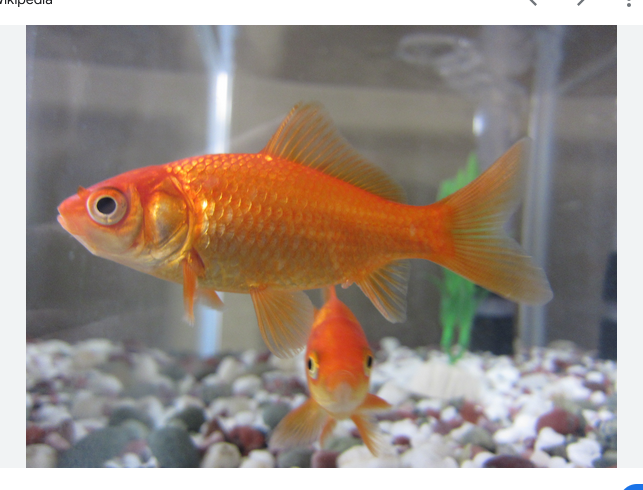

In [3]:
img = Image.open('image.png').convert('RGB')
display(img)

The classes.json file has been taken from [here](https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json) as this pre trained model uses the classes from the ImageNet dataset and we need the class names as the model only provides the index of the predictions and not the name itself. This json file needs to be in the same directory as this notebook for the code to work.

In [4]:
with open("classes.json", "r") as f:
    classes = json.load(f)

The preprocessing portion of this code was generated by ChatGPT as there are a few mandatory and fixed standard pre-processing steps for this model

In [5]:
preprocess = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ImageNet
])
img_tensor = preprocess(img).unsqueeze(0)
output = model(img_tensor)  

with open("classes.json", "r") as f:
    classes = json.load(f)

_, predicted_class = torch.max(output, 1)

print(f"Predicted class: {classes[predicted_class.item()]}")

Predicted class: goldfish


The model was successfully able to identify that the class was in fact the goldfish but how did it come to that conclusion, let's explore in more detail using the SHAP method to see how the model was able to make this prediction

First we can retrieve the ImageNet dataset which this model was trained upon

In [6]:
X, y = shap.datasets.imagenet50()


A portion of the code below was written with the help of the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html)

In [7]:
preprocess_shap = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ImageNet
])

def f(x):
    tmp = torch.stack([preprocess_shap(Image.fromarray(img.astype('uint8'))) for img in x])
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=classes)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [01:10, 35.48s/it]               


At this point we can visualize the SHAP values on sample images

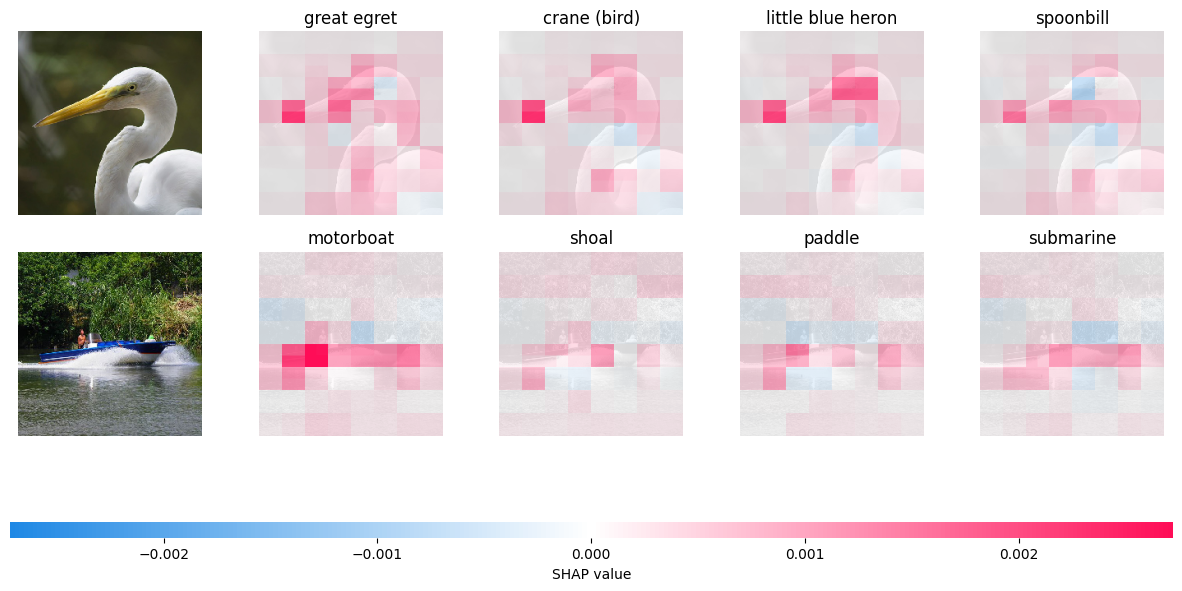

In [8]:
X_normalized = X[1:3].astype(np.float32) / 255.0  # Convert to float32 and normalize

# Visualizing the SHAP values for the normalized images
shap.image_plot(shap_values, X_normalized)
plt.show()

It's clear to see from the plot above that the model certainly takes different parts of images into account. For example, the model classified the bird as the great egret and the most important part of the image that was used to determine the prediction was the beak and head area as they are the darkest shade of pink. However, there are also somewhat important features in the neck area of the bird but it was able to ignore the background as it knew that the background had no bearing on the classification which means this model is definitely able to generalize well.

With the motorboat image, it seems like the model ignored the wake of the boat and really only considered the back of the boat and the deck in order to make this prediction. Of course it also was able to ignore the background pretty well which is a good indication that the model essentially knows what to look for. It was also somewhat able to see the person on the boat which also had some contribution to the model's classification.